# Assignment 1: Sampling and Reproducibility

The code at the end of this file explores contact tracing data about an outbreak of the flu, and demonstrates the dangers of incomplete and non-random samples. This assignment is modified from [Contact tracing can give a biased sample of COVID-19 cases](https://andrewwhitby.com/2020/11/24/contact-tracing-biased/) by Andrew Whitby.

Examine the code below. Identify all stages at which sampling is occurring in the model. Describe in words the sampling procedure, referencing the functions used, sample size, sampling frame, any underlying distributions involved. 


Answer 1

This simulation includes three main stages of sampling, each with distinct procedures and selection criteria. Below is a breakdown of each stage, including the sample sizes, sampling frame, the sampling method used, and any underlying probability distributions.

1. Infection Sampling

Function used: np.random.choice()

Sampling frame: All 1000 individuals (200 wedding + 800 brunch attendees)

Sample size: 10% of 1000 = 100 individuals

Sampling method: Simple random sample without replacement

Distribution involved: Uniform — every individual has equal probability of being selected

Description: Out of 1000 total event attendees, 100 individuals are randomly selected to be infected, based on the ATTACK_RATE = 0.10 parameter.

2. Primary Contact Tracing

Function used: np.random.rand()

Sampling frame: Only the 100 infected individuals

Sample size: Approximately 20% of infected people, based on TRACE_SUCCESS = 0.20

Sampling method: Bernoulli trial for each infected individual

Distribution involved: Bernoulli (random draw from uniform [0, 1])

Description: Each infected individual is independently traced with 20% probability.

3. Secondary Contact Tracing

Function used: Pandas filtering logic based on event and count thresholds

Sampling frame: Events with ≥ 2 traced individuals (based on SECONDARY_TRACE_THRESHOLD = 2)

Sample size: Varies depending on how many events meet the threshold

Sampling method: Deterministic — if an event has 2 or more traced cases, all infected people in that event are traced

Distribution involved: None (logic-based sampling)

Description: If at least two infected individuals from a single event (e.g. wedding or brunch) are already traced in the primary stage, then all infected individuals at that event are also traced.

Question 2


Modify the number of repetitions in the simulation to 10 and 100 (from the original 1000). Run the script multiple times and observe the outputted graphs. Comment on the reproducibility of the results.

Answer 2

Reproducibility with Different Repetition Counts

When we reduce the number of repetitions from 1000 to 10 or 100, we see a clear change in the stability of the results.

- With only 10 repetitions, the output graphs vary significantly between runs. The histograms are rough and inconsistent. This is because small sample sizes are more sensitive to randomness.
- With 100 repetitions, the results are somewhat more stable, but still show noticeable variability across different runs.
- In contrast, the original 1000 repetitions produce smooth and consistent histograms.

This shows that the simulation results are not reproducible by default - each time we run the script, the output changes because the random number generation is not controlled.

To ensure reproducibility, we need to set a random seed


Question 3

Alter the code so that it is reproducible. Describe the changes you made to the code and how they affected the reproducibility of the script. The output needs to produce the same output when run multiple times.

Answer 3

Making the Code Reproducible

To make the simulation reproducible, we need to ensure the random number generator produces the same sequence of random values every time the code runs. This is done by setting a random seed at the beginning of the script.

Changes made:

Added np.random.seed(some_fixed_number) (for example, np.random.seed(42)) before any random operations.

Effect of changes:

The sequence of random choices (infection selection and tracing) becomes the same every time the script runs.

This guarantees that the output graphs and results are consistent and reproducible across multiple runs.

Without this, the randomness causes different outputs each time, reducing reproducibility and making comparisons difficult.

## Code

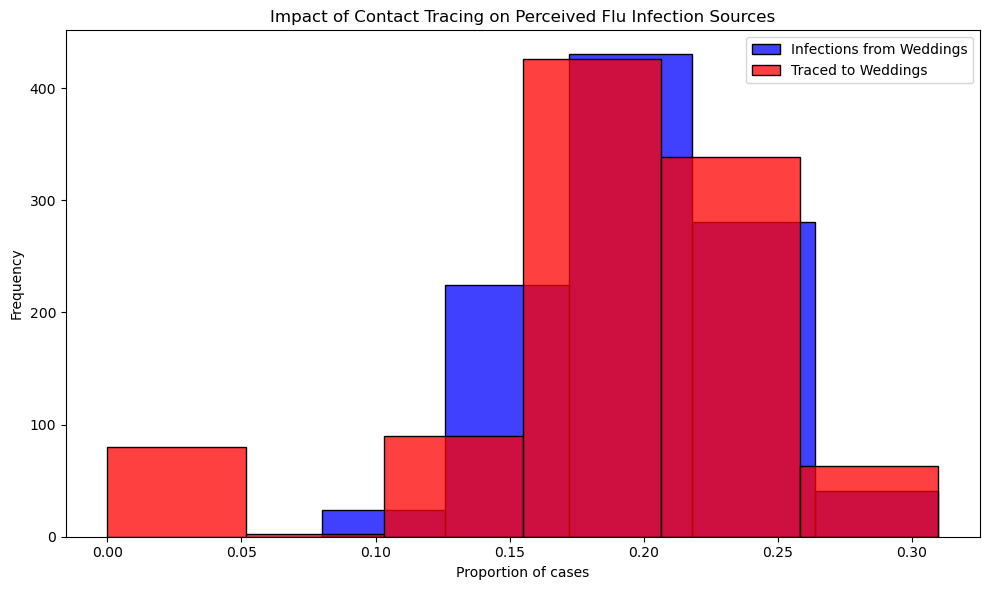

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces

# Run the simulation 1000 times
results = [simulate_event(m) for m in range(1000)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()

## Criteria

|Criteria|Complete|Incomplete|
|--------|----|----|
|Alteration of the code|The code changes made, made it reproducible.|The code is still not reproducible.|
|Description of changes|The author answered questions and explained the reasonings for the changes made well.|The author did not answer questions or explain the reasonings for the changes made well.|

## Submission Information
🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `23:59 - 12/10/2025`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This markdown file (`a1_sampling_and_reproducibility.ipynb`) should be populated with the code changed.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/sampling/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

#### Checklist:
- [ ] Create a branch called `assignment-1`.
- [ ] Ensure that the repository is public.
- [ ] Review [the PR description guidelines](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md#guidelines-for-pull-request-descriptions) and adhere to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via the help channel in Slack. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
